In [1]:
import pandas as pd
import polars as pl
import pylab as plt
import numpy as np

import seaborn as sns
sns.set_style('white')
from scipy.stats import beta

In [2]:
data = pl.read_csv("ai_scores.csv")

data = data.select([
    pl.col("Opponent"),
    (pl.col("Won") + pl.col("Lost")).alias("Games_played"),
    pl.all().exclude("Opponent")
    ])

In [3]:
others = (data
          .filter(pl.col("Games_played") <= 5)
          .sum()
          .with_columns([
              pl.lit("NA").alias("Player Skill"),
              pl.lit("Others").alias("Opponent")
              ])
          )

grouped = (data
           .groupby("Player Skill")
           .agg([
                pl.sum("Games_played"),
                pl.sum("Won"),
                pl.sum("Lost")
                ])
           .select([
               pl.col("Player Skill").alias("Opponent"),
               pl.all().exclude("Player Skill"),
               pl.col("Player Skill")
               ])
           ).sort("Opponent")

total = (data
         .sum()
         .with_columns([
              pl.lit("NA").alias("Player Skill"),
              pl.lit("Total").alias("Opponent")
         ])
)

In [4]:
data = data.filter(pl.col("Games_played") > 5).sort("Opponent")

In [5]:
data.extend(others).extend(grouped).extend(total)

Opponent,Games_played,Won,Lost,Player Skill
str,i64,i64,i64,str
"""Alessandro""",25,17,8,"""Intermediate"""
"""Daniel""",10,8,2,"""Intermediate"""
"""Giacomo A.""",18,10,8,"""Expert"""
"""Giacomo C.""",14,10,4,"""Beginner"""
"""Me""",16,10,6,"""Intermediate"""
"""Silvio""",23,11,12,"""Expert"""
"""Simone""",39,20,19,"""Expert"""
"""Teresa""",13,7,6,"""Expert"""
"""Others""",12,7,5,"""NA"""


In [6]:
# Compute win rate
data = data.with_columns(
    (pl.col("Won") / pl.col("Games_played")).alias("Win_rate")
    )

In [7]:
def compute_confidence_interval(games_played, n_wins, confidence=0.9):
    rv = beta(n_wins+1, games_played-n_wins+1)
    l, u = rv.interval(confidence)
    return f"{l:.2f} - {u:.2f}"

data = data.with_columns(
    data.select([pl.col("Games_played"), pl.col("Won")])
    .apply(lambda r: compute_confidence_interval(r[0], r[1]))
    .select(pl.col("apply").alias("90% CI"))
    )

In [ ]:
(
    data.select(
    pl.all().exclude("Player Skill"),
    pl.col("Player Skill")
    )
    .to_pandas()
    .to_latex(
        buf="thesis/chapters/original-work/player-scores.tex",
        index=False,
        float_format="%.2f"
    )
)

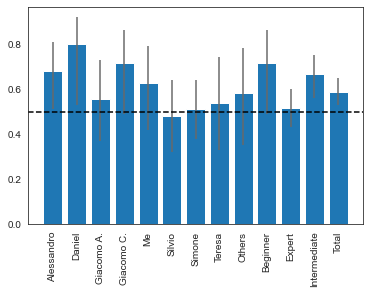

In [ ]:
error = np.stack(data["90% CI"].str.split(" - ").to_numpy()).astype(float) - data["Win_rate"].to_numpy().reshape(-1, 1)
plt.bar(data["Opponent"], data["Win_rate"], yerr=np.abs(error).T, ecolor="dimgray")
# Line at 50%
plt.axhline(0.5, color="black", linestyle="--")
plt.xticks(rotation=90)
plt.ylabel("Win rate")
plt.xlabel("Opponent")

plt.savefig("player-scores.svg", bbox_inches="tight")